In [ ]:
!unzip -qq CCPD2019-dl1.zip

In [12]:
!pip install torchmetrics pybind11 fastwer scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 9.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 6.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.1/296.1 kB 5.3 MB/s eta 0:00:00a 0:00:01


In [13]:
import torch
import torchvision
import fastwer
import torchmetrics
import os
import gc 

import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from PIL import Image

from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

In [2]:
path = 'CCPD2019-dl1/'

dictionary = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽",
             "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁",
             "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵",
             "云", "藏", "陕", "甘", "青", "宁", "新", "警",
             "学", "O", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
       'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R',
       'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', 'O']
unknown = '<U>'
blank = '<B>'

In [3]:
class Tokenizer:
    def __init__(self, labels):
        self.char2id = {}
        self.char2id[unknown] = 0
        self.char2id[blank] = 1
        for i, label in enumerate(labels):
                self.char2id[label] = i + 2
        self.id2char = {v:k for k, v in self.char2id.items()}
        
    def encode(self, label):
        enc_label = [self.char2id[char] if char in self.char2id else self.char2id[unknown] for char in label]
        return enc_label
    
    def __len__(self):
        return len(self.char2id)
    
    def decode(self, enc_list):
        decoded_list = ''
        for i, char in enumerate(enc_list):
            if (char != self.char2id[unknown] and char != self.char2id[blank] and not(i > 0 and char == enc_list[i - 1])):
                decoded_list += self.id2char[char]
        return decoded_list

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, path, transform, tokenizer):
        super().__init__()
        self.files = [file for file in os.listdir(path) if file[0] != '.']
        self.t = transform
        self.labels = [file.split('-')[-1].split('.')[0] for file in self.files]
        self.path = path
        self.alphabet = {}
        self.tokenizer = tokenizer
        self.encoded_labels = [self.tokenizer.encode(label) for label in self.labels]
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, ind):
        image = Image.open(f'{self.path}{self.files[ind]}')
        img = self.t(image)
        label = self.labels[ind]
        return img, label, self.encoded_labels[ind]

In [5]:
tokenizer = Tokenizer(dictionary)

transform = transforms.Compose([
    transforms.Resize((32, 220)),
    transforms.ToTensor(),
])

train_dataset = Dataset(os.path.join(path,'train/'), transform, tokenizer)
test_dataset = Dataset(os.path.join(path,'test/'), transform, tokenizer)

In [7]:
len(train_dataset), len(test_dataset)

(199980, 9999)

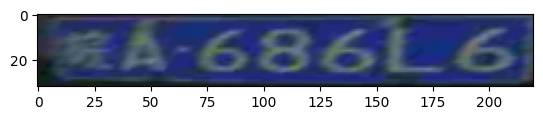

In [18]:
plt.imshow(test_dataset[3][0].permute(1, 2, 0))
plt.show()

In [6]:
class Downsample(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding=1,use_batchnorm=True):
    super().__init__()
    if use_batchnorm:
      self.core=nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
          nn.BatchNorm2d(out_channels),
          nn.ReLU()
      )
    else:
      self.core=nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.ReLU()
    )
  def forward(self, x):
    return self.core(x)

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        Downsample(in_channels=3, out_channels=64, kernel_size=3, stride=1, use_batchnorm=False),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        Downsample(in_channels=64, out_channels=128, kernel_size=3, stride=1),
        nn.MaxPool2d(kernel_size = (1,2), stride = 2),
        Downsample(in_channels=128, out_channels=256, kernel_size=3, stride=1),
        nn.MaxPool2d(kernel_size = (1,2), stride = 2),
        Downsample(in_channels=256, out_channels=128, kernel_size=3, stride=1),
        )
    def forward(self, inputs):
        x = self.layers(inputs)
        return x

In [8]:
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout = 0.1):
        super().__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, dropout = dropout, batch_first = True, bidirectional = True)

    def forward(self, inputs):
        outputs, _ = self.rnn(inputs)
        return outputs

class CRNN(nn.Module):
    

    
    def __init__(self, output_dim,  hidden_dim, max_len = 15, num_layers = 2):
        super().__init__()
        self.encoder = Encoder()
        self.avg_pool = nn.AdaptiveAvgPool2d((max_len, max_len))
        self.rnn = BiLSTM(max_len, hidden_dim, num_layers)
        self.classify_layer = nn.Sequential(
            nn.Linear(hidden_dim * 2, max_len),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(max_len, output_dim)
        )
    
    def forward(self, inputs):
        outp = self.encoder(inputs)
        b, c, h, w = outp.shape
        outp = outp.view(b, c * h, w)
        outp = self.avg_pool(outp)
        outp = outp.transpose(1,2)
        outp = self.rnn(outp)
        outp = self.classify_layer(outp)
        outp = outp.permute(1, 0, 2)
        outp = nn.functional.log_softmax(outp, dim=2)
        return outp

In [9]:
def collate_fn(batch):
    images, labels, encoded_labels = zip(*batch)
    images = torch.stack(images, 0)
    encoded_labels = torch.nn.utils.rnn.pad_sequence(torch.tensor(encoded_labels), batch_first=True, padding_value=1)
    return images, labels, encoded_labels

In [10]:
def train_epoch(model,
               dataset,
               loss,
               optimizer,
               scheduler,
               device):
    model.train()
    epoch_loss = 0
    model = model.to(device)
    for img, label, encoded_label in tqdm(dataset):
        
        batch = img.shape[0]
        
        img = img.to(device)
        
        optimizer.zero_grad()
        
        preds = model(img)
        
        p_labels = torch.full(size = (batch,), fill_value = preds.size(0), dtype = torch.long)
        t_labels = torch.full(size = (batch,), fill_value = encoded_label.size(1), dtype = torch.long)

        b_loss = loss(preds, encoded_label, p_labels, t_labels)
        
        epoch_loss += b_loss.item()
        
        b_loss.backward()
        optimizer.step()
    
    
    return epoch_loss / len(dataset)

In [11]:
def eval_epoch(model,
               dataset,
               loss,
               device):
    model.eval()
    epoch_loss = 0
    model = model.to(device)
    for img, label, encoded_label in tqdm(dataset):
        
        with torch.no_grad():
            batch = img.shape[0]

            img = img.to(device)
            encoded_label = encoded_label.to(device)

            preds = model(img)

            p_labels = torch.full(size = (batch,), fill_value = preds.size(0), dtype = torch.long)
            t_labels = torch.full(size = (batch,), fill_value = encoded_label.size(1), dtype = torch.long)

            b_loss = loss(preds, encoded_label, p_labels, t_labels)

            epoch_loss += b_loss.item()
    
    return epoch_loss / len(dataset)

In [12]:
def train_model(model, 
                train_dataset,
                test_dataset,
                batch_size,
                epochs,
                loss,
                optimizer,
                scheduler,
                device):
    
    model.cuda()
    loss.to(device)
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                                  batch_size = batch_size, 
                                                  shuffle = False, 
                                                  collate_fn = collate_fn)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size = batch_size, 
                                                   shuffle = True, 
                                                   collate_fn = collate_fn)
    for epoch_i in range(epochs):
        print(f'Epoch {epoch_i+1}')
        train_loss = train_epoch(model, train_dataloader, loss, optimizer, scheduler, device)
        eval_loss = eval_epoch(model, test_dataloader, loss, device)
        scheduler.step(eval_loss)
        print(f'Train CTC: {train_loss}')
        print(f'Eval CTC: {eval_loss}')
        print()
    torch.save(model, f'model_ep{epoch_i+1}.pt')
        

In [13]:
model = CRNN(max_len = 15, hidden_dim = 200, output_dim = len(train_dataset.tokenizer), num_layers = 2) 

CTC =  nn.CTCLoss(blank = 1, reduction = 'mean', zero_infinity = True)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=5, verbose=True) 

gc.collect()
torch.cuda.empty_cache()

train_model(
    model = model,
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    batch_size = 128,
    loss = CTC,
    optimizer = optimizer,
    scheduler = scheduler,
    epochs = 10,
    device = 'cuda'
)

Epoch 1


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train CTC: 3.0028658341842815
Eval CTC: 2.0103080891355685

Epoch 2


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train CTC: 0.9231137104013069
Eval CTC: 0.2196903477741193

Epoch 3


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train CTC: 0.20089744116755837
Eval CTC: 0.10001567105137849

Epoch 4


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train CTC: 0.10375405463818473
Eval CTC: 0.07591616317535503

Epoch 5


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train CTC: 0.06926006894089133
Eval CTC: 0.0693979582431007

Epoch 6


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train CTC: 0.05219624730772074
Eval CTC: 0.06486983366216285

Epoch 7


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train CTC: 0.04214400670807558
Eval CTC: 0.07545892772252989

Epoch 8


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train CTC: 0.035413823933033745
Eval CTC: 0.06186418796563816

Epoch 9


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train CTC: 0.03099549728221071
Eval CTC: 0.05557966011663298

Epoch 10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train CTC: 0.027535500582867682
Eval CTC: 0.0651401086055373



In [14]:
def predict(model, dataset, tokenizer, device = 'cuda'):
    model.eval()
    preds = []
    real = []
    epoch_loss = 0
    model = model.to(device)
    test_dataloader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = False, collate_fn = collate_fn)
    for img, label, encoded_label in tqdm(test_dataloader):
        with torch.no_grad():
            batch = img.shape[0]
            img = img.to(device)
            encoded_label = encoded_label.to(device)
            pred = model(img)
            preds.append(tokenizer.decode(pred.argmax(2).squeeze(1).tolist()))
            real.append(label)
    
    return preds, real

In [15]:
accuracy = torchmetrics.CharErrorRate()

preds, real_labels = predict(model, test_dataset, tokenizer)

print('CER:', accuracy(preds, real_labels).item())
print('Accuracy:', accuracy_score(preds, real_labels))

  0%|          | 0/9999 [00:00<?, ?it/s]

CER: 6.995199680328369
Accuracy: 0.9487948794879488
